In [21]:
from __future__ import annotations

In [22]:
from collections import deque
from graphviz import Digraph
import math

In [27]:
class Value:
    def __init__(self, data:float, label:str = "", 
                 parents:tuple[Value] = (), op: str = "",
                 _backward:function = lambda: None) -> None:
        self.data = data
        self.label = label
        self.parents = parents
        self.op = op
        self.grad = 0
        self._backward = _backward # calculates gradients of parents
        
    def backward(self):
        topological_sort = []
        visited = set()
        def build_topological_sort(node): # dfs
            if node not in visited:
                visited.add(node)
                for parent in node.parents:
                    build_topological_sort(parent)
                topological_sort.append(node) # post-order traversal
        build_topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(topological_sort): # reversed post-order dfs -> topological
            node._backward()
        
    def backward_bfs_fucked(self): # bfs not topological: 2 unequal paths to same dest 
        self.grad = 1 # derivative with respect to itself
        
        visited = set()
        visit_queue = deque([self])
        while visit_queue:
            current_node = visit_queue.popleft()
            if current_node not in visited: # parent can have multiple kids
                print(current_node)
                current_node._backward()
                visit_queue.extend(current_node.parents)
                visited.add(current_node)    
    
    def __add__(self, other: Value) -> Value:
        out = Value(self.data + other.data, 
                    parents=(self, other), op="+")
        
        def _backward():
            self.grad += out.grad * 1 # accumulate gradients
            other.grad += out.grad * 1
        out._backward = _backward

        return out
    
    def __sub__(self, other: Value) -> Value:
        return self + (-other)
    
    def __mul__(self, other: Value) -> Value:
        out = Value(self.data * other.data, 
                    parents=(self, other), op="*")
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other: Value) -> Value:
        return self * other**-1
    
    def __neg__(self) -> Value:
        return self * Value(-1)
        
    def exp(self) -> Value:
        out = Value(math.exp(self.data),
                    parents=(self, ), op="exp")
        
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out
    
    def __pow__(self, other: float) -> Value:
        out = Value(self.data ** other,
                    parents=(self, ), op=f"**{other}")
        
        def _backward():
            self.grad += out.grad * (other * self.data**(other-1))
        out._backward = _backward
        
        return out
    
    def tanh(self) -> Value:
        out = Value((math.exp(2*self.data) - 1) / (math.exp(2*self.data) + 1),
                    parents=(self, ), op="tanh")
        
        def _backward():
            self.grad += out.grad * (1 - out.data**2)
        out._backward = _backward
        
        return out
            
    def __repr__(self) -> str:
        return f"Value(label={self.label}, data={self.data})"
    
    def draw_graph(self) -> None:
        graph = Digraph(format="svg", graph_attr={"rankdir": "LR"})
        nodes: set[Value] = set()
        edges: set[Value] = set()
        visit_queue = deque([self])
        while visit_queue: # bfs to build
            current_node = visit_queue.popleft()
            if current_node not in nodes:
                for parent in current_node.parents:
                    edge = (parent, current_node)
                    edges.add(edge)
                nodes.add(current_node)
                visit_queue.extend(current_node.parents)
                
        for node in nodes:
            uid = str(id(node))
            graph.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (node.label, node.data, node.grad), shape="record")
            if node.op:
                graph.node(name=f"{uid}-{node.op}", label=node.op)
                graph.edge(f"{uid}-{node.op}", uid)
        for (n1, n2) in edges:
            graph.edge(str(id(n1)), f"{str(id(n2))}-{n2.op}")
        
        return graph

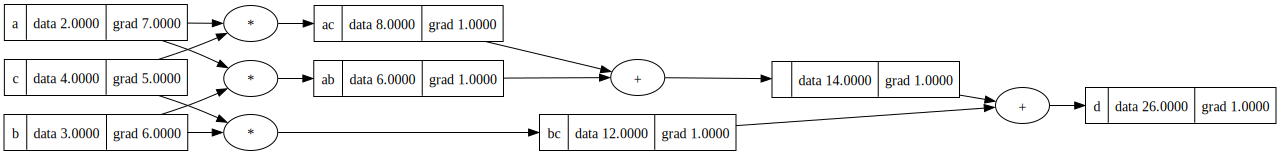

In [28]:
a = Value(2, label="a")
b = Value(3, label="b")
c = Value(4, label="c")
ab = a * b; ab.label = "ab"
ac = a * c; ac.label = "ac"
bc = b * c; bc.label = "bc"
d = ab + ac + bc; d.label = "d"
d.backward()
d.draw_graph()

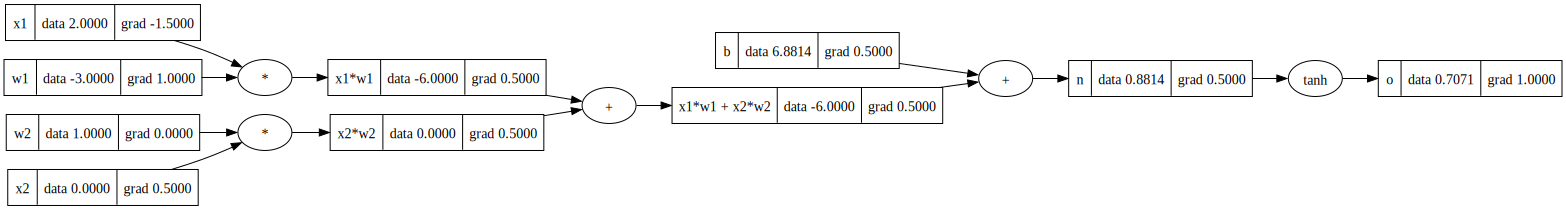

In [29]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
o.draw_graph()

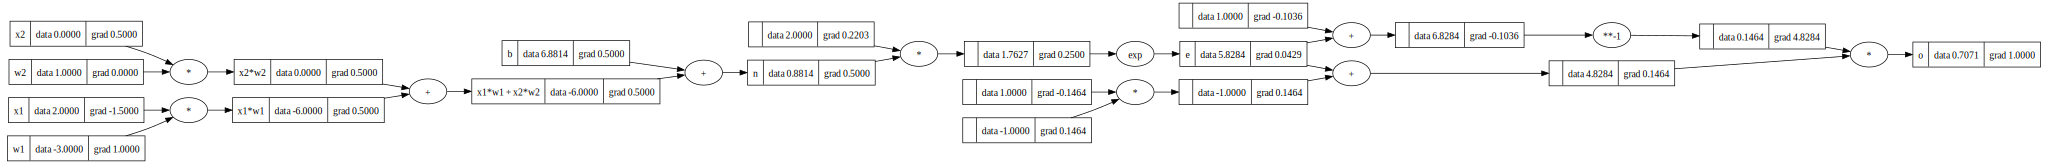

In [30]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (Value(2)*n).exp(); e.label = "e"
o = (e - Value(1)) / (e + Value(1)); o.label = 'o'
# ----
o.backward()
o.draw_graph()